<a href="https://colab.research.google.com/github/microprediction/automl-notebooks/blob/main/univariate_autosklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall numpy -y

Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Successfully uninstalled numpy-1.21.6


In [ ]:
!pip install auto-sklearn
!pip install --upgrade pandas 

In [1]:
import pandas as pd 
import numpy as np 
from pprint import pprint
import sklearn.metrics
import autosklearn.regression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from pprint import pprint

# Data to fit 

In [16]:
url = 'https://github.com/microprediction/schooled/blob/main/localoutput/sarima/output/massaged.csv?raw=true'
df = pd.read_csv(url)
df.rename(inplace=True,columns={'y_next':'x'})

In [25]:
x_cols = [ c for c in df.columns if 'y_' in c ]
assert 'x' not in x_cols 
y = df['wiggly'].values   # <--- Model we want surrogate for
X = df[x_cols].values
z = df['x'].values        # <--- The target (next value in the series)
y1 = 0.9*y + 0.1*z        # <--- Train on combination of model and target, maybe

In [26]:
X = X.astype(np.float32)
n_test = 5000
n_train = len(df)-2*n_test
X_train, y_train, z_train = X[:n_train], y1[:n_train], z[:n_train]
X_test, y_test, z_test = X[n_train:(n_train+n_test)], y1[n_train:(n_train+n_test)], z[n_train:(n_train+n_test)]
X_val, y_val, z_val = X[(n_train+n_test):], y1[(n_train+n_test):], z[(n_train+n_test):]

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="./tmp",
)
automl.fit(X_train, y_train, dataset_name="sarima")

[WARNING] [2022-10-28 21:11:54,454:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-10-28 21:12:25,600:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='./tmp')

In [27]:
print(automl.leaderboard())

          rank  ensemble_weight            type      cost   duration
model_id                                                            
5            1             0.74  ard_regression  0.003239   8.275779
6            2             0.26             mlp  0.003826  28.329997


In [28]:
y_train_hat = automl.predict(X_train)
y_test_hat = automl.predict(X_test)
y_val_hat = automl.predict(X_val)

print("Train surrogate R2 score:", sklearn.metrics.r2_score(y_train, y_train_hat))
print("Test surrogate R2 score:", sklearn.metrics.r2_score(y_test, y_test_hat))
print("Test surrogate R2 score:", sklearn.metrics.r2_score(y_val, y_val_hat))
print("Train surrogate MSE score:", sklearn.metrics.mean_squared_error(y_train, y_train_hat))
print("Test surrogate MSE score:", sklearn.metrics.mean_squared_error(y_test, y_test_hat))
print("Val surrogate MSE score:", sklearn.metrics.mean_squared_error(y_val, y_val_hat))

print("Val model error:", sklearn.metrics.mean_squared_error(y_val, z_val))
print('Val MSE relative to last value:',sklearn.metrics.mean_squared_error(y_val, y_val_hat)/sklearn.metrics.mean_squared_error(y_val, np.zeros_like(y_val)))
# How does surrogate error compare to original?
print('Val surrogate prediction error relative to model:',sklearn.metrics.mean_squared_error(z_val, y_val_hat)/sklearn.metrics.mean_squared_error(z_val, y_val))




Train surrogate R2 score: 0.9968591344316055
Test surrogate R2 score: 0.9967719876206265
Test surrogate R2 score: 0.9965788060787097
Train surrogate MSE score: 0.0043201553211221376
Test surrogate MSE score: 0.00434235987233904
Val surrogate MSE score: 0.004682253427737463
Val model error: 0.03238237682974857
Val MSE relative to last value: 0.003420911512990482
Val surrogate prediction error relative to model: 1.0884180343841463


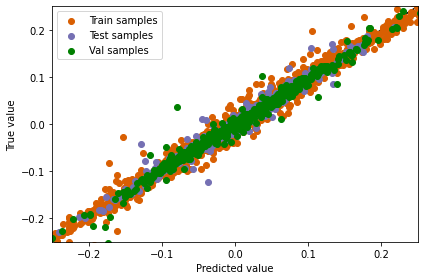

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(train_predictions, y_train, label="Train samples", c="#d95f02")
plt.scatter(test_predictions, y_test, label="Test samples", c="#7570b3")
plt.scatter(val_predictions, y_val, label="Val samples", c="green")
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([-0.25, 0.25], [-0.25, 0.25], c="k", zorder=0)
plt.xlim([-0.25, 0.25])
plt.ylim([-0.25, 0.25])
plt.tight_layout()
plt.show()